# Gözetimsiz Öğrenme ile Müşteri Segmentasyonu (Customer Segmentation with Unsupervised Learning)
---

# İş Problemi (Business Problem)
---
- Unsupervised Learning yöntemleriyle (Kmeans, Hierarchical Clustering )  müşteriler kümelere ayrılıp ve davranışları gözlemlenmek istenmektedir.


- FLO müşterilerini segmentlere ayırıp bu segmentlere göre pazarlama stratejileri belirlemek istiyor. Buna yönelik olarak müşterilerin davranışları tanımlanacak ve bu
davranışlardaki öbeklenmelere göre gruplar oluşturulacak.

# Veri Seti Hikayesi
---
- Veri seti son alışverişlerini 2020 - 2021 yıllarında OmniChannel(hem online hem offline) olarak yapan müşterilerin geçmiş alışveriş davranışlarından elde edilen bilgilerden oluşmaktadır.

- 20.000 gözlem, 13 değişken

- master_id: Eşsiz müşteri numarası
- order_channel : Alışveriş yapılan platforma ait hangi kanalın kullanıldığı (Android, ios, Desktop, Mobile, Offline)
- last_order_channel : En son alışverişin yapıldığı kanal
- first_order_date : Müşterinin yaptığı ilk alışveriş tarihi
- last_order_date : Müşterinin yaptığı son alışveriş tarihi
- last_order_date_online : Muşterinin online platformda yaptığı son alışveriş tarihi
- last_order_date_offline : Muşterinin offline platformda yaptığı son alışveriş tarihi
- order_num_total_ever_online : Müşterinin online platformda yaptığı toplam alışveriş sayısı
- order_num_total_ever_offline : Müşterinin offline'da yaptığı toplam alışveriş sayısı
- customer_value_total_ever_offline : Müşterinin offline alışverişlerinde ödediği toplam ücret
- customer_value_total_ever_online : Müşterinin online alışverişlerinde ödediği toplam ücret
- interested_in_categories_12 : Müşterinin son 12 ayda alışveriş yaptığı kategorilerin listesi
- store_type : 3 farklı companyi ifade eder. A company'sinden alışveriş yapan kişi B'dende yaptı ise A,B şeklinde yazılmıştır.


**GÖREV 1: Veriyi Hazırlama**
* 1. flo_data_20K.csv.csv verisini okuyunuz.
* 2. Müşterileri segmentlerken kullanacağınız değişkenleri seçiniz. Tenure(Müşterinin yaşı), Recency (en son kaç gün önce alışveriş yaptığı) gibi yeni değişkenler oluşturabilirsiniz.

In [2]:

#pip install yellowbrick
import pandas as pd
import yellowbrick
from scipy import stats
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.width', 1000)


In [3]:
df_ = pd.read_csv("flo_data_20k.csv")
df = df_.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   master_id                          19945 non-null  object 
 1   order_channel                      19945 non-null  object 
 2   last_order_channel                 19945 non-null  object 
 3   first_order_date                   19945 non-null  object 
 4   last_order_date                    19945 non-null  object 
 5   last_order_date_online             19945 non-null  object 
 6   last_order_date_offline            19945 non-null  object 
 7   order_num_total_ever_online        19945 non-null  float64
 8   order_num_total_ever_offline       19945 non-null  float64
 9   customer_value_total_ever_offline  19945 non-null  float64
 10  customer_value_total_ever_online   19945 non-null  float64
 11  interested_in_categories_12        19945 non-null  obj

In [5]:
df.columns

Index(['master_id', 'order_channel', 'last_order_channel', 'first_order_date', 'last_order_date', 'last_order_date_online', 'last_order_date_offline', 'order_num_total_ever_online', 'order_num_total_ever_offline', 'customer_value_total_ever_offline', 'customer_value_total_ever_online', 'interested_in_categories_12'], dtype='object')

In [6]:
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.00,1.00,139.99,799.38,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.00,2.00,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.00,2.00,189.97,395.35,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.00,1.00,39.99,81.98,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.00,1.00,49.99,159.99,[AKTIFSPOR]


In [7]:
# tarih değişkenine çevirme
date_columns = df.columns[df.columns.str.contains("date")]
df[date_columns] = df[date_columns].apply(pd.to_datetime)

In [8]:
df["last_order_date"].max() # 2021-05-30
analysis_date = dt.datetime(2021,6,1)

In [9]:
df["recency"] = (analysis_date - df["last_order_date"]).astype('timedelta64[D]') # en son kaç gün önce alışveriş yaptı
df["tenure"] = (df["last_order_date"]-df["first_order_date"]).astype('timedelta64[D]')

In [11]:
model_df = df[["order_num_total_ever_online","order_num_total_ever_offline","customer_value_total_ever_offline","customer_value_total_ever_online","recency","tenure"]]
model_df.head()


,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,4.00,1.00,139.99,799.38,95.00,119.00
1,19.00,2.00,159.97,1853.58,105.00,1469.00
2,3.00,2.00,189.97,395.35,186.00,366.00
3,1.00,1.00,39.99,81.98,135.00,11.00
4,1.00,1.00,49.99,159.99,86.00,582.00


In [12]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 6 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   order_num_total_ever_online        19945 non-null  float64
 1   order_num_total_ever_offline       19945 non-null  float64
 2   customer_value_total_ever_offline  19945 non-null  float64
 3   customer_value_total_ever_online   19945 non-null  float64
 4   recency                            19945 non-null  float64
 5   tenure                             19945 non-null  float64
dtypes: float64(6)
memory usage: 935.0 KB


### GÖREV 2: K-Means ile Müşteri Segmentasyonu

In [13]:
# 1. Değişkenleri standartlaştırınız.
#SKEWNESS
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column],color = "g")
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return


C:\Users\Gizem\AppData\Local\Temp\ipykernel_15276\1035882423.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_skew[column],color = "g")
C:\Users\Gizem\AppData\Local\Temp\ipykernel_15276\1035882423.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_skew[column],color = "g")
C:\Users\Giz

order_num_total_ever_online's: Skew: 10.487693811914617, : SkewtestResult(statistic=152.9996121784795, pvalue=0.0)
order_num_total_ever_offline's: Skew: 20.328068075845888, : SkewtestResult(statistic=184.13121810134328, pvalue=0.0)
customer_value_total_ever_offline's: Skew: 16.29952194789334, : SkewtestResult(statistic=173.73456097827923, pvalue=0.0)


C:\Users\Gizem\AppData\Local\Temp\ipykernel_15276\1035882423.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_skew[column],color = "g")
C:\Users\Gizem\AppData\Local\Temp\ipykernel_15276\1035882423.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_skew[column],color = "g")


customer_value_total_ever_online's: Skew: 20.08427979804232, : SkewtestResult(statistic=183.56317267711924, pvalue=0.0)
recency's: Skew: 0.6172488156761073, : SkewtestResult(statistic=32.86977170491703, pvalue=5.944419293752164e-237)


C:\Users\Gizem\AppData\Local\Temp\ipykernel_15276\1035882423.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_skew[column],color = "g")


tenure's: Skew: 1.756242119042335, : SkewtestResult(statistic=71.08790370222574, pvalue=0.0)


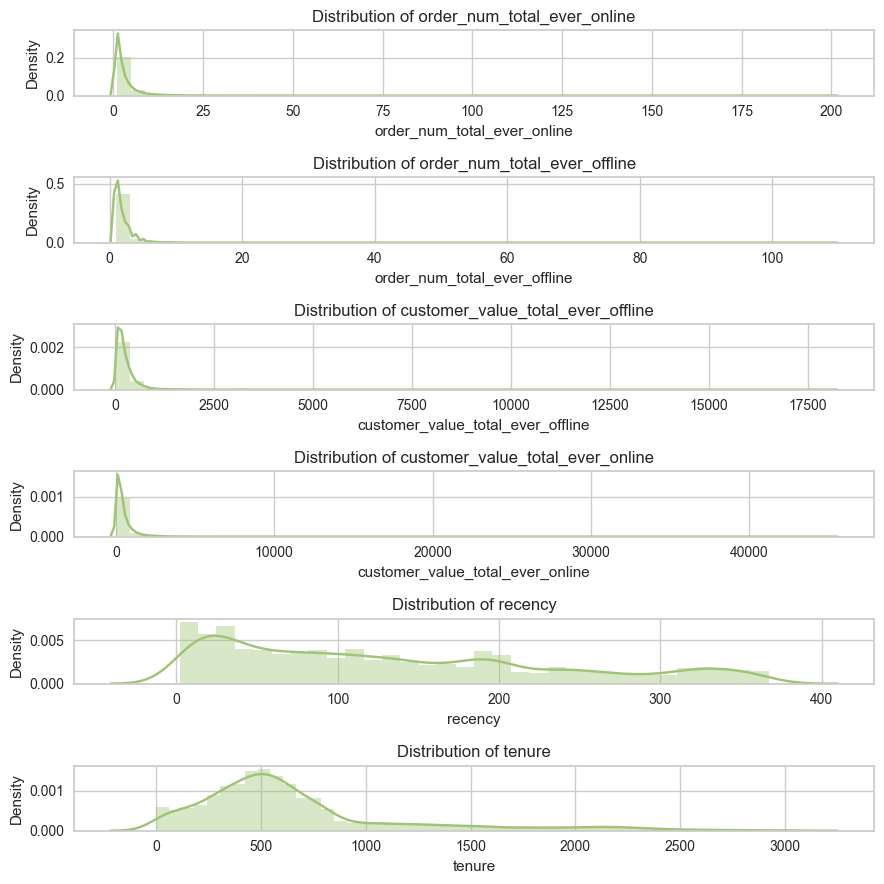

In [19]:
plt.figure(figsize=(9, 9))
plt.subplot(6, 1, 1)
check_skew(model_df,'order_num_total_ever_online')
plt.subplot(6, 1, 2)
check_skew(model_df,'order_num_total_ever_offline')
plt.subplot(6, 1, 3)
check_skew(model_df,'customer_value_total_ever_offline')
plt.subplot(6, 1, 4)
check_skew(model_df,'customer_value_total_ever_online')
plt.subplot(6, 1, 5)
check_skew(model_df,'recency')
plt.subplot(6, 1, 6)
check_skew(model_df,'tenure')
plt.tight_layout()
plt.savefig('before_transform.png', format='png', dpi=1000)
plt.show()

In [20]:

# Normal dağılımın sağlanması için Log transformation uygulanması
model_df['order_num_total_ever_online']=np.log1p(model_df['order_num_total_ever_online'])
model_df['order_num_total_ever_offline']=np.log1p(model_df['order_num_total_ever_offline'])
model_df['customer_value_total_ever_offline']=np.log1p(model_df['customer_value_total_ever_offline'])
model_df['customer_value_total_ever_online']=np.log1p(model_df['customer_value_total_ever_online'])
model_df['recency']=np.log1p(model_df['recency'])
model_df['tenure']=np.log1p(model_df['tenure'])
model_df.head()

C:\Users\Gizem\AppData\Local\Temp\ipykernel_15276\3521902504.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['order_num_total_ever_online']=np.log1p(model_df['order_num_total_ever_online'])
C:\Users\Gizem\AppData\Local\Temp\ipykernel_15276\3521902504.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['order_num_total_ever_offline']=np.log1p(model_df['order_num_total_ever_offline'])
C:\Users\Gizem\AppData\Local\Temp\ipykernel_15276\3521902504.py:4: SettingWithCopyWarning: 
A value is t

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,1.61,0.69,4.95,6.69,4.56,4.79
1,3.00,1.10,5.08,7.53,4.66,7.29
2,1.39,1.10,5.25,5.98,5.23,5.91
3,0.69,0.69,3.71,4.42,4.91,2.48
4,0.69,0.69,3.93,5.08,4.47,6.37


In [21]:

# Scaling
sc = MinMaxScaler((0, 1))
model_scaling = sc.fit_transform(model_df)
model_df=pd.DataFrame(model_scaling,columns=model_df.columns)
model_df.head()


,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,0.20,0.00,0.34,0.50,0.72,0.60
1,0.50,0.10,0.36,0.60,0.74,0.91
2,0.15,0.10,0.39,0.41,0.86,0.74
3,0.00,0.00,0.18,0.22,0.79,0.31
4,0.00,0.00,0.21,0.30,0.70,0.79


c:\Users\Gizem\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Gizem\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Gizem\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Gizem\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

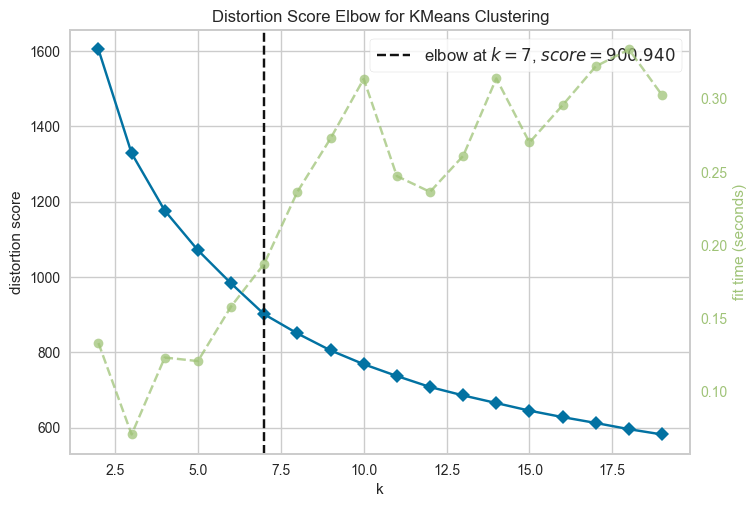

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [22]:

# 2. Optimum küme sayısını belirleyiniz.
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2, 20))
elbow.fit(model_df)
elbow.show()

In [23]:

# 3. Modelinizi oluşturunuz ve müşterilerinizi segmentleyiniz.
k_means = KMeans(n_clusters = 7, random_state= 42).fit(model_df)
segments=k_means.labels_+1
segments

final_df = df[["master_id","order_num_total_ever_online","order_num_total_ever_offline","customer_value_total_ever_offline","customer_value_total_ever_online","recency","tenure"]]
final_df["segment"] = segments
final_df.head()


c:\Users\Gizem\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Gizem\AppData\Local\Temp\ipykernel_15276\2247229405.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["segment"] = segments


,master_id,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure,segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,4.00,1.00,139.99,799.38,95.00,119.00,7
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,19.00,2.00,159.97,1853.58,105.00,1469.00,7
2,69b69676-1a40-11ea-941b-000d3a38a36f,3.00,2.00,189.97,395.35,186.00,366.00,7
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.00,1.00,39.99,81.98,135.00,11.00,4
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,1.00,1.00,49.99,159.99,86.00,582.00,5


In [24]:

# 4. Herbir segmenti istatistiksel olarak inceleyeniz.
final_df.groupby("segment").agg({"order_num_total_ever_online":["mean","min","max","std"],
                                  "order_num_total_ever_offline":["mean","min","max","std"],
                                  "customer_value_total_ever_offline":["mean","min","max","std"],
                                  "customer_value_total_ever_online":["mean","min","max","std"],
                                  "recency":["mean","min","max","std"],
                                  "tenure":["mean","min","max","count","std"]})

order_num_total_ever_online                  order_num_total_ever_offline                  customer_value_total_ever_offline                        customer_value_total_ever_online                         recency                    tenure                           
                               mean  min    max  std                         mean  min    max  std                              mean    min      max    std                             mean    min      max     std    mean   min    max   std   mean   min     max count    std
segment                                                                                                                                                                                                                                                                          
1                              1.42 1.00   5.00 0.65                         1.28 1.00   5.00 0.50                            145.16  10.00   829.98  92.89                           210.07  12.99  1519.17  140.50  225.71 88.00 367.00 80.39 489.85 52.00 2820.00  5448 393.66
2                              2.20 1.00  12.00 1.56                         2.10 1.00  14.00 1.62                            293.82  12.99  3425.14 279.99                           377.70  23.99  3444.08  313.18   10.00  2.00  27.00  5.15 665.01  2.00 3031.00  1841 442.25
3                              1.84 1.00  13.00 1.15                         3.77 1.00 109.00 4.03                            551.78 106.82 18119.14 532.90                           283.36  14.99  2587.20  218.61  153.29 22.00 366.00 81.51 729.95 20.00 2911.00  3269 489.58
4                              1.40 1.00   8.00 0.88                         1.13 1.00   6.00 0.42                            192.39  12.99  1333.00 151.64                           250.37  19.99  3476.81  270.30  139.55  4.00 367.00 92.27  37.24  0.00  132.00   828  30.06
5                              1.61 1.00   6.00 0.81                         1.48 1.00   6.00 0.73                            185.84  12.99  1406.85 133.17                           250.00  14.00  1307.33  170.24   50.33 15.00 109.00 21.94 604.52 43.00 2828.00  3340 375.40
6                              8.63 2.00 200.00 8.54                         2.10 1.00  36.00 1.75                            278.89  12.99  3589.65 275.91                          1475.52 265.97 45220.13 1999.09   32.72  2.00 109.00 18.03 966.63 18.00 3034.00  1974 612.68
7                              6.37 1.00  55.00 4.68                         1.54 1.00  16.00 0.89                            184.41  10.49  1644.79 149.68                           985.51 180.96 12038.18  744.26  180.09 55.00 367.00 79.68 943.90 26.00 2964.00  3245 629.73

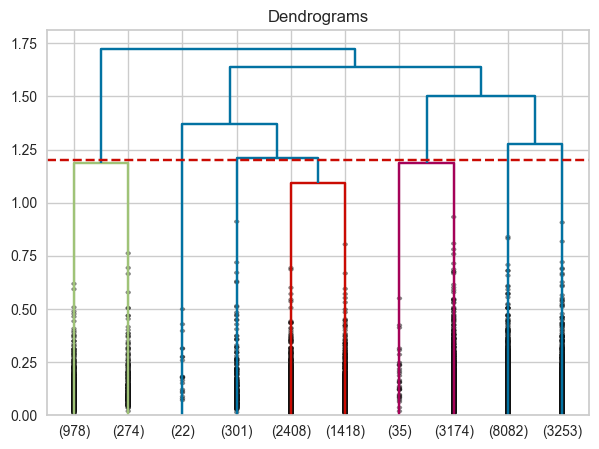

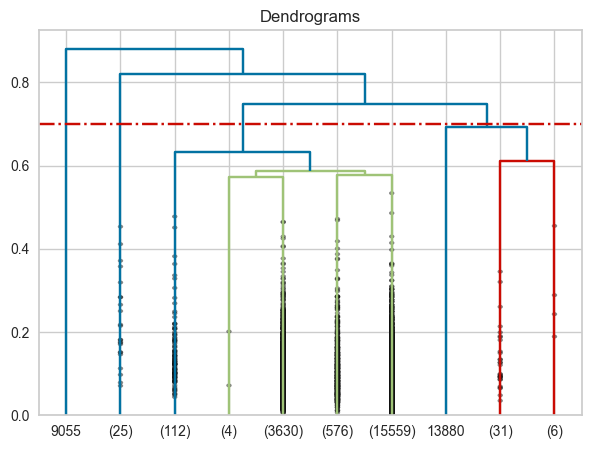

In [25]:
# GÖREV 3: Hierarchical Clustering ile Müşteri Segmentasyonu
###############################################################

# 1. Görev 2'de standarlaştırdığınız dataframe'i kullanarak optimum küme sayısını belirleyiniz.
hc_complete = linkage(model_df, 'complete')

plt.figure(figsize=(7, 5))
plt.title("Dendrograms")
dend = dendrogram(hc_complete,
           truncate_mode="lastp",
           p=10,
           show_contracted=True,
           leaf_font_size=10)
plt.axhline(y=1.2, color='r', linestyle='--')
plt.show()

hc_average = linkage(model_df, 'average')

plt.figure(figsize=(7, 5))
plt.title("Dendrograms")
dend = dendrogram(hc_average,
           truncate_mode="lastp",
           p=10,
           show_contracted=True,
           leaf_font_size=10)
plt.axhline(y=0.7, color='r', linestyle='-.')
plt.show()

In [26]:

# 2. Modelinizi oluşturunuz ve müşterileriniz segmentleyiniz.
hc = AgglomerativeClustering(n_clusters=5)
segments = hc.fit_predict(model_df)

In [27]:
final_df = df[["master_id","order_num_total_ever_online","order_num_total_ever_offline","customer_value_total_ever_offline","customer_value_total_ever_online","recency","tenure"]]
final_df["segment"] = segments
final_df.head()

C:\Users\Gizem\AppData\Local\Temp\ipykernel_15276\2142485556.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["segment"] = segments


,master_id,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure,segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,4.00,1.00,139.99,799.38,95.00,119.00,3
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,19.00,2.00,159.97,1853.58,105.00,1469.00,2
2,69b69676-1a40-11ea-941b-000d3a38a36f,3.00,2.00,189.97,395.35,186.00,366.00,0
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.00,1.00,39.99,81.98,135.00,11.00,3
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,1.00,1.00,49.99,159.99,86.00,582.00,0


In [28]:

# 3. Herbir segmenti istatistiksel olarak inceleyeniz.
final_df.groupby("segment").agg({"order_num_total_ever_online":["mean","min","max","std"],
                                  "order_num_total_ever_offline":["mean","min","max","std"],
                                  "customer_value_total_ever_offline":["mean","min","max","std"],
                                  "customer_value_total_ever_online":["mean","min","max","std"],
                                  "recency":["mean","min","max","std"],
                                  "tenure":["mean","min","max","count","std"]})



order_num_total_ever_online                  order_num_total_ever_offline                  customer_value_total_ever_offline                       customer_value_total_ever_online                         recency                    tenure                            
                               mean  min    max  std                         mean  min    max  std                              mean   min      max    std                             mean    min      max     std    mean   min    max   std   mean    min     max count    std
segment                                                                                                                                                                                                                                                                          
0                              1.37 1.00  13.00 0.71                         1.99 1.00 109.00 2.65                            261.97 10.49 18119.14 360.42                           208.07  12.99 30688.47  368.25  183.03 18.00 367.00 94.92 569.72   3.00 2911.00  8747 452.33
1                              3.75 1.00  49.00 4.21                         1.82 1.00  24.00 1.40                            240.98 12.99  3425.14 240.89                           638.61  19.99 12545.37  769.49   23.96  2.00 108.00 16.27 715.07  18.00 3034.00  4994 459.17
2                              6.91 1.00 200.00 8.23                         3.08 1.00  16.00 1.74                            427.12 12.99  2963.24 302.55                          1104.12 139.98 45220.13 1700.73  131.57 14.00 365.00 77.08 914.49 109.00 3016.00  2396 608.44
3                              1.40 1.00   6.00 0.78                         1.20 1.00   6.00 0.49                            200.69 12.99  1019.97 146.02                           227.42  26.99  1389.60  168.09   92.52  4.00 367.00 70.00  80.26   0.00  555.00   985  89.43
4                              4.74 1.00  24.00 3.08                         1.12 1.00   4.00 0.35                            123.46 10.00  1049.92  90.59                           722.77  59.98  7665.28  532.07  196.52 36.00 367.00 82.76 876.95  71.00 2964.00  2823 594.04